# NYC Yellow Taxi Data - Preprocessing and Cleaning Pipeline

This notebook implements the **data cleaning pipeline** based on EDA findings and using the `TaxiDataPreprocessor` class.

## 🎯 Preprocessing Objectives:

### 📊 **Critical Quality Issues Identified in EDA:**
1. **28.01% records** with total_amount discrepancies (average difference: $2.50)
2. **Widespread negative values**: 20,506 fares (0.57%), 20,709 totals (0.58%)
3. **Invalid VendorID**: 14 records with ID=5 (not documented in TLC dictionary)
4. **Incorrect dates**: Ranges 2003-2022 (should be only May 2022)
5. **73,587 trips with 0 passengers** (2.05%)
6. **46,438 trips with 0 distance** (1.29%)
7. **135 anomalous tips** in cash payments

### ⏰ **Temporal Issues:**
- 3,030 trips with negative/zero duration (0.08%)
- 48,944 trips < 1 minute (1.36%)  
- 5,084 trips > 3 hours (0.14%)

### 🎯 **Cleaning Strategy:**
- ✅ **Validate basic structure** of the dataset
- 🧹 **Clean temporal fields** (invalid dates, anomalous durations)
- 🏷️ **Clean categorical fields** (invalid values according to TLC dictionary)
- 💰 **Clean monetary fields** (negative values, discrepancies)
- 🧠 **Validate and correct total_amount**
- 🎯 **Remove extreme outliers**

> **Note**: Feature engineering is performed in a separate module (`features.py`)

## 1. Setup and Library Import

In [1]:
# Import necessary libraries
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from datetime import datetime

# Visualization configuration
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
warnings.filterwarnings('ignore')

# Add src to path for imports
project_root = Path().cwd().parent
src_path = project_root / 'src'
sys.path.append(str(src_path))

print(f"📁 Project directory: {project_root}")
print(f"🐍 Python version: {sys.version}")
print(f"📊 Pandas version: {pd.__version__}")
print(f"🔢 NumPy version: {np.__version__}")

📁 Project directory: d:\VSCode\nyc_taxi_project
🐍 Python version: 3.11.0 (main, Oct 24 2022, 18:26:48) [MSC v.1933 64 bit (AMD64)]
📊 Pandas version: 2.3.3
🔢 NumPy version: 2.3.5


## 2. Preprocessor Import and Configuration

In [2]:
# Import preprocessor and configuration
from data.preprocess import TaxiDataPreprocessor
from config.paths import RAW_DATA, PROCESSED_DATA
from config.settings import PREPROCESSING_PARAMS

# Verify file paths
print("📂 PATH CONFIGURATION:")
print(f"   Raw data: {RAW_DATA}")
print(f"   Processed data: {PROCESSED_DATA}")
print(f"   Raw file exists: {Path(RAW_DATA).exists()}")

print(f"\n⚙️ PREPROCESSING PARAMETERS:")
for key, value in PREPROCESSING_PARAMS.items():
    print(f"   {key}: {value}")

# Initialize preprocessor
preprocessor = TaxiDataPreprocessor()
print(f"\n✅ TaxiDataPreprocessor initialized successfully")

2025-11-30 11:47:53,556 - INFO - TaxiDataPreprocessor initialized


📂 PATH CONFIGURATION:
   Raw data: d:\VSCode\nyc_taxi_project\data\raw\yellow_tripdata_2022-05.parquet
   Processed data: d:\VSCode\nyc_taxi_project\data\processed\processed_data.parquet
   Raw file exists: True

⚙️ PREPROCESSING PARAMETERS:
   target_year: 2022
   target_month: 5
   min_trip_duration_minutes: 1
   max_trip_duration_minutes: 180
   min_passengers: 1
   max_passengers: 6
   min_fare_amount: 0.01
   min_trip_distance: 0.01
   outlier_method: iqr
   outlier_factor: 1.5
   remove_extreme_outliers: True
   valid_vendor_ids: [1, 2, 6, 7]
   valid_ratecode_ids: [1, 2, 3, 4, 5, 6, 99]
   valid_payment_types: [0, 1, 2, 3, 4, 5, 6]
   valid_store_flags: ['Y', 'N']
   max_fare_amount_percentile: 0.99
   max_total_amount_percentile: 0.99
   max_trip_distance_percentile: 0.99
   create_temporal_features: True
   create_ratio_features: True
   create_categorical_indicators: True
   create_distance_categories: True
   data_year: 2022
   data_month: 5

✅ TaxiDataPreprocessor initializ

## 3. Data Loading and Initial Validation

In [3]:
# Load raw data
print("📥 LOADING RAW DATA...")
print("="*50)

data = preprocessor.load_data()

print(f"\n📊 BASIC DATASET INFORMATION:")
print(f"   Shape: {data.shape}")
print(f"   Memory size: {data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"   Data types by column:")

# Show data types
for col, dtype in data.dtypes.items():
    print(f"     {col:<25}: {dtype}")

print(f"\n🔍 FIRST 5 RECORDS:")
display(data.head())

2025-11-30 11:51:23,065 - INFO - Loading data from: d:\VSCode\nyc_taxi_project\data\raw\yellow_tripdata_2022-05.parquet


📥 LOADING RAW DATA...


2025-11-30 11:51:26,669 - INFO - Data loaded: 3,588,295 rows, 19 columns



📊 BASIC DATASET INFORMATION:
   Shape: (3588295, 19)
   Memory size: 687.06 MB
   Data types by column:
     VendorID                 : int64
     tpep_pickup_datetime     : datetime64[us]
     tpep_dropoff_datetime    : datetime64[us]
     passenger_count          : float64
     trip_distance            : float64
     RatecodeID               : float64
     store_and_fwd_flag       : object
     PULocationID             : int64
     DOLocationID             : int64
     payment_type             : int64
     fare_amount              : float64
     extra                    : float64
     mta_tax                  : float64
     tip_amount               : float64
     tolls_amount             : float64
     improvement_surcharge    : float64
     total_amount             : float64
     congestion_surcharge     : float64
     airport_fee              : float64

🔍 FIRST 5 RECORDS:
   Memory size: 687.06 MB
   Data types by column:
     VendorID                 : int64
     tpep_pickup_date

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-05-01 00:00:36,2022-05-01 00:19:18,1.0,4.1,1.0,N,246,151,2,17.0,3.0,0.5,0.00,0.0,0.3,20.80,2.5,0.0
1,1,2022-05-01 00:27:44,2022-05-01 00:41:33,1.0,2.3,1.0,N,238,74,2,11.0,3.0,0.5,0.00,0.0,0.3,14.80,2.5,0.0
2,1,2022-05-01 00:59:00,2022-05-01 01:14:22,1.0,4.2,1.0,N,163,260,2,15.5,3.0,0.5,0.00,0.0,0.3,19.30,2.5,0.0
3,1,2022-05-01 00:48:18,2022-05-01 01:28:02,1.0,0.0,1.0,N,79,182,1,41.2,0.0,0.5,0.00,0.0,0.3,42.00,0.0,0.0
4,1,2022-05-01 00:28:26,2022-05-01 00:37:49,1.0,1.6,1.0,N,238,75,1,7.5,3.0,0.5,2.25,0.0,0.3,13.55,2.5,0.0


## 4. Basic Structure Validation

2025-11-30 11:51:40,958 - INFO - === BASIC STRUCTURE VALIDATION ===


🔍 BASIC STRUCTURE VALIDATION


2025-11-30 11:51:48,795 - INFO - Columnas faltantes: set()
2025-11-30 11:51:48,797 - INFO - Columnas adicionales: set()
2025-11-30 11:51:48,800 - INFO - Registros con valores faltantes: 647620
2025-11-30 11:51:48,802 - INFO - Registros duplicados: 0
2025-11-30 11:51:48,797 - INFO - Columnas adicionales: set()
2025-11-30 11:51:48,800 - INFO - Registros con valores faltantes: 647620
2025-11-30 11:51:48,802 - INFO - Registros duplicados: 0



📊 VALIDATION RESULTS:
   Total records: 3,588,295
   Total columns: 19
   Memory usage: 687.06 MB

📋 MISSING COLUMNS:
   ✅ All expected columns are present

📋 ADDITIONAL COLUMNS:
   ✅ No unexpected additional columns

🔢 MISSING VALUES BY COLUMN:


,Column,Missing_Values,Percentage
0,passenger_count,129524,3.61%
1,RatecodeID,129524,3.61%
2,store_and_fwd_flag,129524,3.61%
3,congestion_surcharge,129524,3.61%
4,airport_fee,129524,3.61%



🔄 DUPLICATE RECORDS:
   Duplicates found: 0 (0.00%)


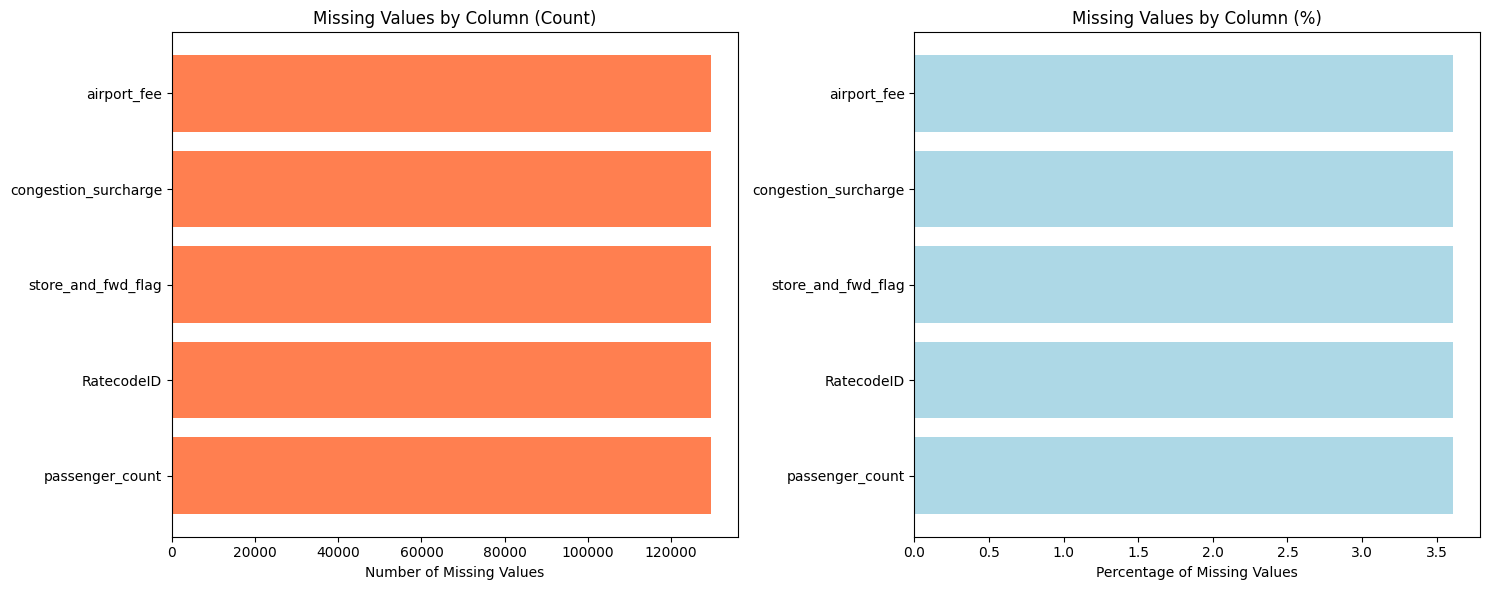

In [4]:
# Execute basic structure validation
print("🔍 BASIC STRUCTURE VALIDATION")
print("="*50)

validation_stats = preprocessor.validate_basic_structure()

print(f"\n📊 VALIDATION RESULTS:")
print(f"   Total records: {validation_stats['total_records']:,}")
print(f"   Total columns: {validation_stats['total_columns']}")
print(f"   Memory usage: {validation_stats['memory_usage_mb']:.2f} MB")

print(f"\n📋 MISSING COLUMNS:")
if validation_stats['missing_columns']:
    for col in validation_stats['missing_columns']:
        print(f"   ❌ {col}")
else:
    print("   ✅ All expected columns are present")

print(f"\n📋 ADDITIONAL COLUMNS:")
if validation_stats['extra_columns']:
    for col in validation_stats['extra_columns']:
        print(f"   ➕ {col}")
else:
    print("   ✅ No unexpected additional columns")

print(f"\n🔢 MISSING VALUES BY COLUMN:")
if validation_stats['missing_values']:
    missing_df = pd.DataFrame([
        {
            'Column': col, 
            'Missing_Values': info['count'], 
            'Percentage': f"{info['percentage']:.2f}%"
        }
        for col, info in validation_stats['missing_values'].items()
    ]).sort_values('Missing_Values', ascending=False)
    
    display(missing_df)
else:
    print("   ✅ No missing values in the dataset")

print(f"\n🔄 DUPLICATE RECORDS:")
dup_info = validation_stats['duplicates']
print(f"   Duplicates found: {dup_info['count']:,} ({dup_info['percentage']:.2f}%)")

# Visualización de valores faltantes
if validation_stats['missing_values']:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Bar chart of missing values
    missing_counts = [info['count'] for info in validation_stats['missing_values'].values()]
    missing_cols = list(validation_stats['missing_values'].keys())
    
    ax1.barh(missing_cols, missing_counts, color='coral')
    ax1.set_title('Missing Values by Column (Count)')
    ax1.set_xlabel('Number of Missing Values')
    
    # Percentage chart
    missing_pcts = [info['percentage'] for info in validation_stats['missing_values'].values()]
    
    ax2.barh(missing_cols, missing_pcts, color='lightblue')
    ax2.set_title('Missing Values by Column (%)')
    ax2.set_xlabel('Percentage of Missing Values')
    
    plt.tight_layout()
    plt.show()
else:
    print("📊 No missing values to visualize")

## 5. Temporal Fields Cleaning

2025-11-30 11:52:02,312 - INFO - === DATETIME FIELDS CLEANING ===


🕒 TEMPORAL FIELDS CLEANING

📊 Records before temporal cleaning: 3,588,295


2025-11-30 11:52:02,698 - INFO - Records with dates outside 2022-5: 143 (0.00%)
2025-11-30 11:52:03,414 - INFO - Filtered 143 records with invalid dates
2025-11-30 11:52:03,414 - INFO - Filtered 143 records with invalid dates
2025-11-30 11:52:03,616 - INFO - Records with invalid duration: 54,011 (1.51%)
2025-11-30 11:52:03,616 - INFO - Records with invalid duration: 54,011 (1.51%)
2025-11-30 11:52:04,967 - INFO - Filtered 54,011 records with invalid duration
2025-11-30 11:52:04,969 - INFO - Removed records due to date/duration: 54,154
2025-11-30 11:52:04,972 - INFO - Remaining records: 3,534,141
2025-11-30 11:52:04,967 - INFO - Filtered 54,011 records with invalid duration
2025-11-30 11:52:04,969 - INFO - Removed records due to date/duration: 54,154
2025-11-30 11:52:04,972 - INFO - Remaining records: 3,534,141



🧹 TEMPORAL CLEANING RESULTS:
   Records processed: 3,588,295
   Final records: 3,534,141
   Records removed: 54,154
   Percentage removed: 1.51%

🔍 TEMPORAL DATA QUALITY POST-CLEANING:
   Pickup date range: 2022-05-01 00:00:00 to 2022-05-31 23:59:59
   Dropoff date range: 2022-05-01 00:01:58 to 2022-06-01 01:03:01

   Duration statistics (minutes):
   Min: 1.00, Max: 179.90
   Mean: 16.64, Median: 12.85
   Mean: 16.64, Median: 12.85


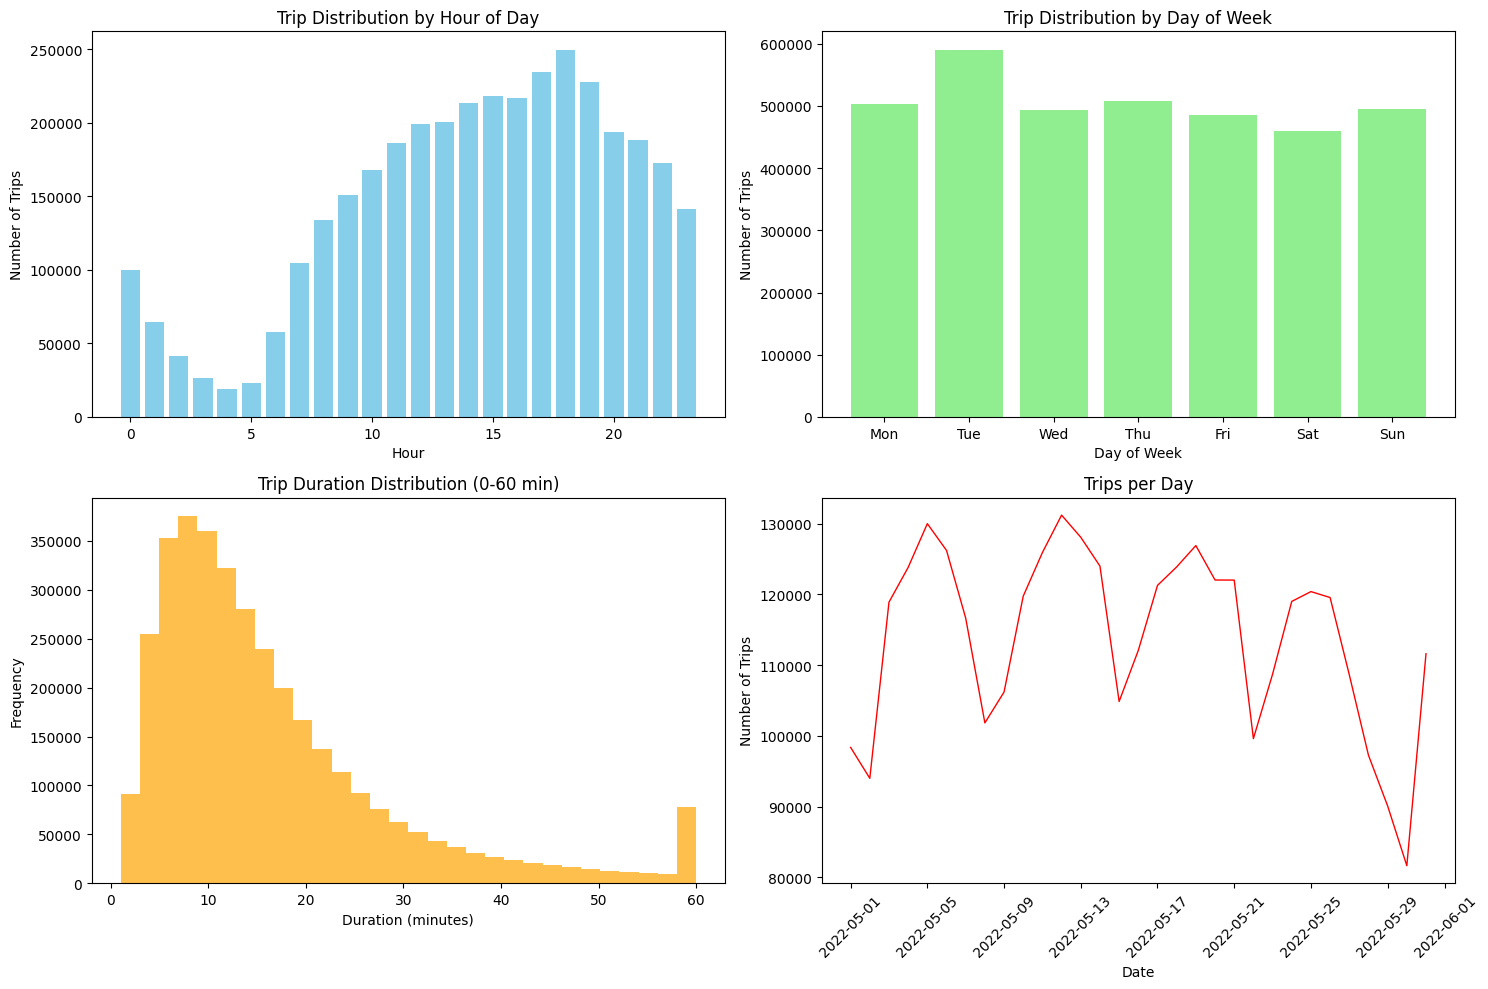

In [5]:
# Execute temporal data cleaning
print("🕒 TEMPORAL FIELDS CLEANING")
print("="*50)

# Get statistics before cleaning
initial_count = len(preprocessor.df)
print(f"\n📊 Records before temporal cleaning: {initial_count:,}")

# Execute temporal cleaning
cleaned_temporal = preprocessor.clean_datetime_fields()
temporal_stats = preprocessor.preprocessing_stats['datetime_cleaning']

print(f"\n🧹 TEMPORAL CLEANING RESULTS:")
print(f"   Records processed: {temporal_stats['initial_count']:,}")
print(f"   Final records: {temporal_stats['final_count']:,}")
print(f"   Records removed: {temporal_stats['removed_records']:,}")
print(f"   Percentage removed: {temporal_stats['removal_percentage']:.2f}%")

# Verify temporal data quality after cleaning
if len(preprocessor.df) > 0:
    print(f"\n🔍 TEMPORAL DATA QUALITY POST-CLEANING:")
    
    # Verify date ranges
    min_pickup = preprocessor.df['tpep_pickup_datetime'].min()
    max_pickup = preprocessor.df['tpep_pickup_datetime'].max()
    min_dropoff = preprocessor.df['tpep_dropoff_datetime'].min()
    max_dropoff = preprocessor.df['tpep_dropoff_datetime'].max()
    
    print(f"   Pickup date range: {min_pickup} to {max_pickup}")
    print(f"   Dropoff date range: {min_dropoff} to {max_dropoff}")
    
    # Verify durations if column exists
    if 'trip_duration_minutes' in preprocessor.df.columns:
        durations = preprocessor.df['trip_duration_minutes']
        
        print(f"\n   Duration statistics (minutes):")
        print(f"   Min: {durations.min():.2f}, Max: {durations.max():.2f}")
        print(f"   Mean: {durations.mean():.2f}, Median: {durations.median():.2f}")
        
        # Temporal distribution visualization
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Distribution by hour of day
        pickup_hour = preprocessor.df['tpep_pickup_datetime'].dt.hour
        hourly_counts = pickup_hour.value_counts().sort_index()
        
        axes[0,0].bar(hourly_counts.index, hourly_counts.values, color='skyblue')
        axes[0,0].set_title('Trip Distribution by Hour of Day')
        axes[0,0].set_xlabel('Hour')
        axes[0,0].set_ylabel('Number of Trips')
        
        # Distribution by day of week
        pickup_weekday = preprocessor.df['tpep_pickup_datetime'].dt.dayofweek
        weekday_counts = pickup_weekday.value_counts().sort_index()
        weekday_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
        
        axes[0,1].bar(range(7), [weekday_counts.get(i, 0) for i in range(7)], color='lightgreen')
        axes[0,1].set_title('Trip Distribution by Day of Week')
        axes[0,1].set_xlabel('Day of Week')
        axes[0,1].set_ylabel('Number of Trips')
        axes[0,1].set_xticks(range(7))
        axes[0,1].set_xticklabels(weekday_names)
        
        # Trip duration distribution (histogram)
        axes[1,0].hist(durations.clip(0, 60), bins=30, color='orange', alpha=0.7)
        axes[1,0].set_title('Trip Duration Distribution (0-60 min)')
        axes[1,0].set_xlabel('Duration (minutes)')
        axes[1,0].set_ylabel('Frequency')
        
        # Time series of trips per day
        daily_trips = preprocessor.df.groupby(preprocessor.df['tpep_pickup_datetime'].dt.date).size()
        axes[1,1].plot(daily_trips.index, daily_trips.values, color='red', linewidth=1)
        axes[1,1].set_title('Trips per Day')
        axes[1,1].set_xlabel('Date')
        axes[1,1].set_ylabel('Number of Trips')
        axes[1,1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
else:
    print("⚠️ No data remains after temporal cleaning!")

## 6. Categorical Fields Cleaning

2025-11-30 11:52:37,338 - INFO - === CLEANING CATEGORICAL FIELDS ===


2025-11-30 11:52:37,446 - INFO - Invalid VendorIDs: 14


🏷️ CATEGORICAL FIELDS CLEANING

📊 Records before categorical cleaning: 3,534,141


2025-11-30 11:52:38,403 - INFO - Records with invalid passenger_count: 198,167
2025-11-30 11:52:41,274 - INFO - Records removed due to categorical fields: 198,181
2025-11-30 11:52:41,274 - INFO - Records removed due to categorical fields: 198,181



🧹 CATEGORICAL CLEANING RESULTS:
   Records processed: 3,534,141
   Final records: 3,335,960
   Records removed: 198,181
   Percentage removed: 5.61%

🔍 CATEGORICAL FIELDS DISTRIBUTION POST-CLEANING:


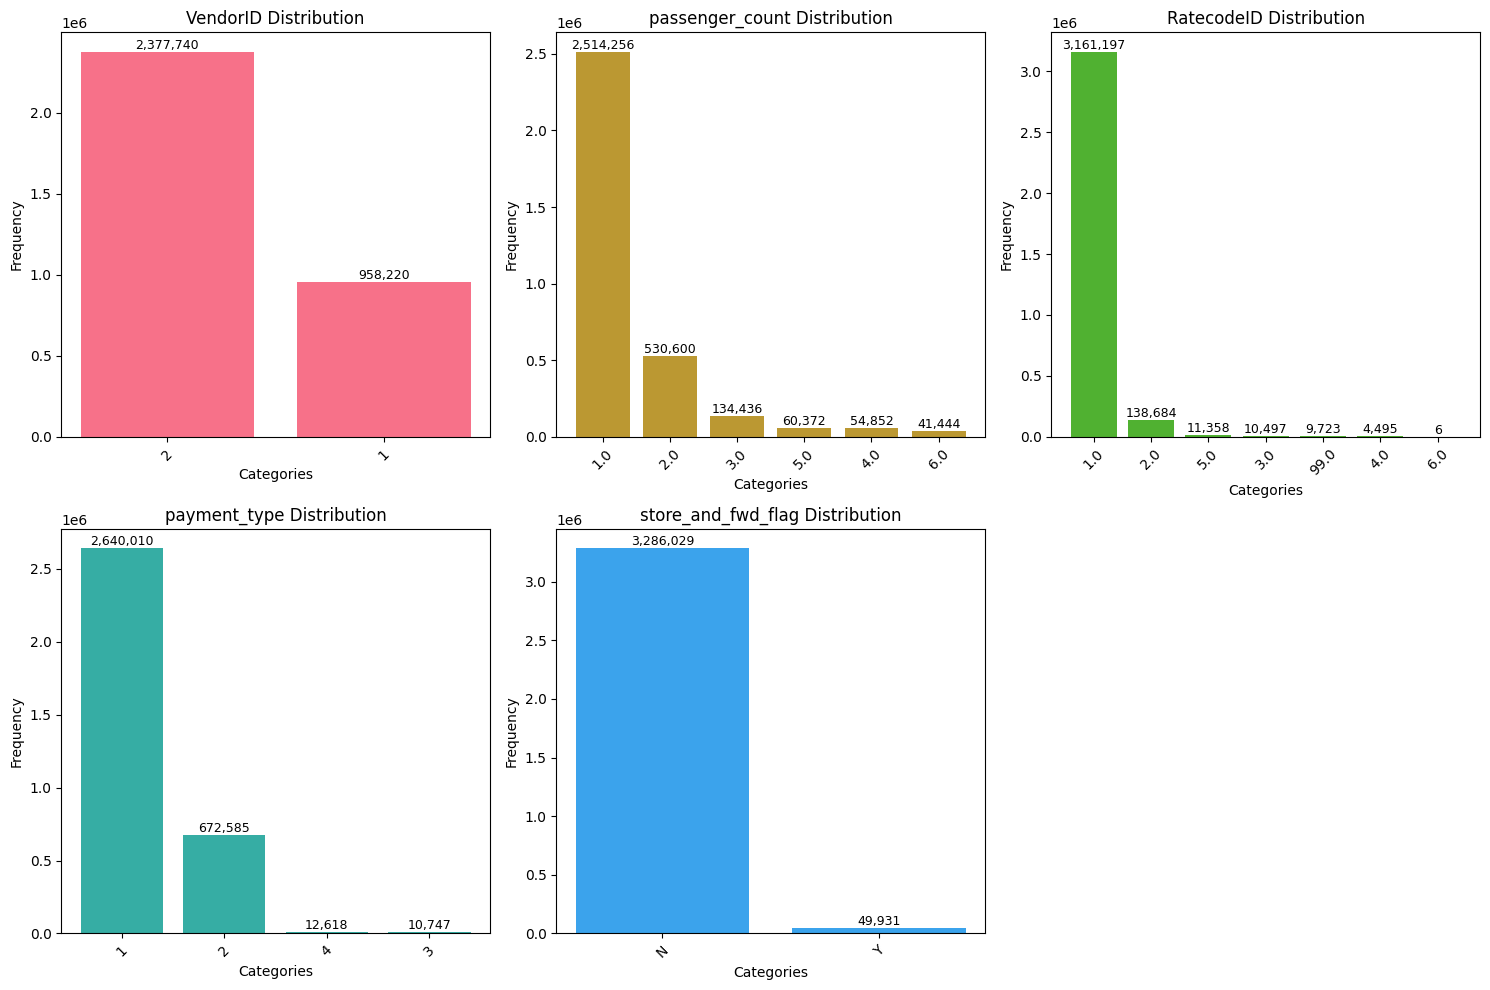


   📊 VendorID:
      2: 2,377,740 (71.28%)
      1: 958,220 (28.72%)

   📊 passenger_count:
      1.0: 2,514,256 (75.37%)
      2.0: 530,600 (15.91%)
      3.0: 134,436 (4.03%)
      5.0: 60,372 (1.81%)
      4.0: 54,852 (1.64%)
      6.0: 41,444 (1.24%)

   📊 RatecodeID:
      1.0: 3,161,197 (94.76%)
      2.0: 138,684 (4.16%)
      5.0: 11,358 (0.34%)
      3.0: 10,497 (0.31%)
      99.0: 9,723 (0.29%)
      4.0: 4,495 (0.13%)
      6.0: 6 (0.00%)

   📊 payment_type:
      1: 2,640,010 (79.14%)
      2: 672,585 (20.16%)
      4: 12,618 (0.38%)
      3: 10,747 (0.32%)

   📊 store_and_fwd_flag:
      N: 3,286,029 (98.50%)
      Y: 49,931 (1.50%)
      N: 3,286,029 (98.50%)
      Y: 49,931 (1.50%)


In [6]:
# Execute categorical fields cleaning
print("🏷️ CATEGORICAL FIELDS CLEANING")
print("="*50)

# Get statistics before cleaning
initial_count = len(preprocessor.df)
print(f"\n📊 Records before categorical cleaning: {initial_count:,}")

# Execute categorical cleaning
cleaned_categorical = preprocessor.clean_categorical_fields()
categorical_stats = preprocessor.preprocessing_stats['categorical_cleaning']

print(f"\n🧹 CATEGORICAL CLEANING RESULTS:")
print(f"   Records processed: {categorical_stats['initial_count']:,}")
print(f"   Final records: {categorical_stats['final_count']:,}")
print(f"   Records removed: {categorical_stats['removed_records']:,}")
print(f"   Percentage removed: {categorical_stats['removal_percentage']:.2f}%")

# Verify categorical fields distribution after cleaning
if len(preprocessor.df) > 0:
    print(f"\n🔍 CATEGORICAL FIELDS DISTRIBUTION POST-CLEANING:")
    
    # Visualize categorical distributions
    categorical_fields = ['VendorID', 'passenger_count', 'RatecodeID', 'payment_type', 'store_and_fwd_flag']
    existing_fields = [field for field in categorical_fields if field in preprocessor.df.columns]
    
    if existing_fields:
        n_fields = len(existing_fields)
        n_cols = min(3, n_fields)
        n_rows = (n_fields + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
        if n_fields == 1:
            axes = [axes]
        elif n_rows == 1:
            axes = axes.flatten() if n_cols > 1 else [axes]
        else:
            axes = axes.flatten()
        
        for i, field in enumerate(existing_fields):
            if i < len(axes):
                value_counts = preprocessor.df[field].value_counts()
                
                # Create bar chart
                axes[i].bar(range(len(value_counts)), value_counts.values, color=f'C{i}')
                axes[i].set_title(f'{field} Distribution')
                axes[i].set_xlabel('Categories')
                axes[i].set_ylabel('Frequency')
                axes[i].set_xticks(range(len(value_counts)))
                axes[i].set_xticklabels([str(x) for x in value_counts.index], rotation=45)
                
                # Show values above bars
                for j, v in enumerate(value_counts.values):
                    axes[i].text(j, v, f'{v:,}', ha='center', va='bottom', fontsize=9)
        
        # Hide unused subplots
        for i in range(len(existing_fields), len(axes)):
            axes[i].set_visible(False)
        
        plt.tight_layout()
        plt.show()
    
    # Show detailed statistics
    for field in existing_fields:
        print(f"\n   📊 {field}:")
        value_counts = preprocessor.df[field].value_counts()
        for value, count in value_counts.head(10).items():
            percentage = (count / len(preprocessor.df)) * 100
            print(f"      {value}: {count:,} ({percentage:.2f}%)")
        
        if len(value_counts) > 10:
            print(f"      ... and {len(value_counts) - 10} more values")
else:
    print("⚠️ No data remains after categorical cleaning!")

## 7. Monetary Fields Cleaning

2025-11-30 11:52:54,904 - INFO - === CLEANING MONETARY FIELDS ===
2025-11-30 11:52:54,918 - INFO - Negative values in fare_amount: 15,405
2025-11-30 11:52:54,918 - INFO - Negative values in fare_amount: 15,405


💰 MONETARY FIELDS CLEANING

📊 Records before monetary cleaning: 3,335,960


2025-11-30 11:52:55,865 - INFO - Negative values in total_amount: 118
2025-11-30 11:52:56,915 - INFO - Trips with fare_amount = 0: 460
2025-11-30 11:52:56,915 - INFO - Trips with fare_amount = 0: 460
2025-11-30 11:52:57,972 - INFO - Trips with distance 0: 14,032
2025-11-30 11:52:57,972 - INFO - Trips with distance 0: 14,032
2025-11-30 11:52:58,786 - INFO - Anomalous tips in cash payments: 60
2025-11-30 11:52:58,786 - INFO - Anomalous tips in cash payments: 60
2025-11-30 11:52:58,901 - INFO - Extremely high fares removed: 1,009
2025-11-30 11:52:58,901 - INFO - Extremely high fares removed: 1,009
2025-11-30 11:52:59,702 - INFO - Records removed due to monetary fields: 31,024
2025-11-30 11:52:59,702 - INFO - Records removed due to monetary fields: 31,024



🧹 MONETARY CLEANING RESULTS:
   Records processed: 3,335,960
   Final records: 3,304,936
   Records removed: 31,024
   Percentage removed: 0.93%

🔍 MONETARY FIELDS STATISTICS POST-CLEANING:


,fare_amount,tip_amount,total_amount,trip_distance
count,3304936.00,3304936.00,3304936.00,3304936.00
mean,14.79,2.78,21.73,3.66
std,12.81,3.16,16.54,17.39
min,0.01,0.00,0.31,0.01
25%,7.00,1.00,12.35,1.18
50%,10.50,2.16,15.96,1.95
75%,16.50,3.45,23.15,3.68
max,156.00,408.00,845.55,29445.65


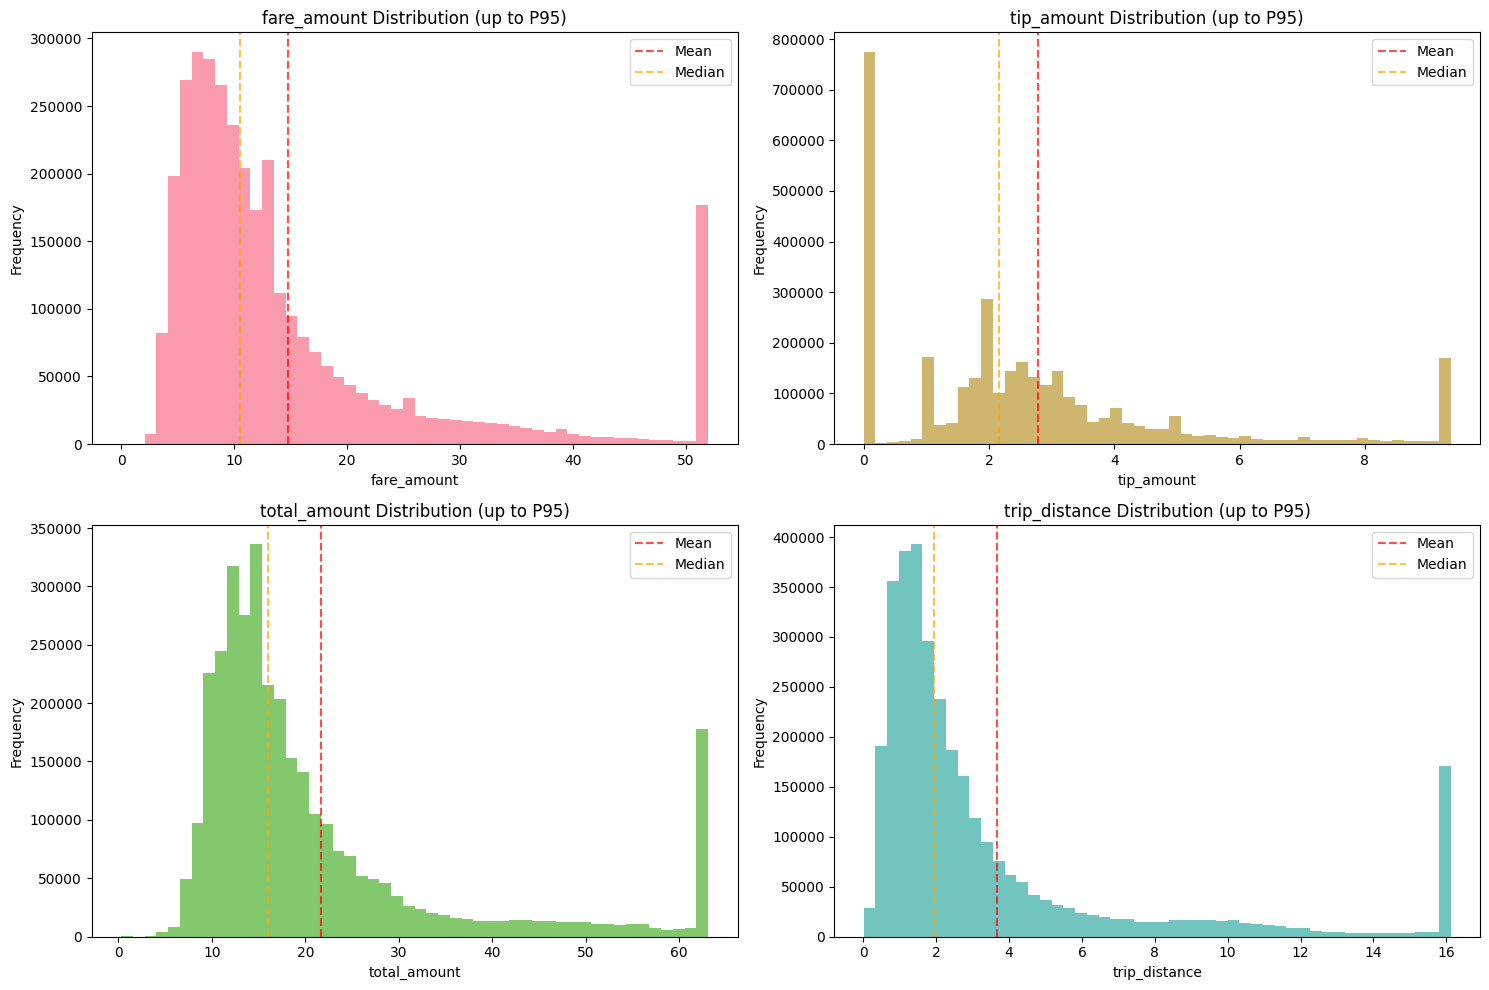


📊 REMAINING EXTREME VALUES:
   fare_amount: 33,027 values > P99 ($53.50)
   tip_amount: 33,028 values > P99 ($14.14)
   total_amount: 31,656 values > P99 ($79.62)
   trip_distance: 32,963 values > P99 ($20.28)
   total_amount: 31,656 values > P99 ($79.62)
   trip_distance: 32,963 values > P99 ($20.28)


In [7]:
# Execute monetary fields cleaning
print("💰 MONETARY FIELDS CLEANING")
print("="*50)

# Get statistics before cleaning
initial_count = len(preprocessor.df)
print(f"\n📊 Records before monetary cleaning: {initial_count:,}")

# Execute monetary cleaning
cleaned_monetary = preprocessor.clean_monetary_fields()
monetary_stats = preprocessor.preprocessing_stats['monetary_cleaning']

print(f"\n🧹 MONETARY CLEANING RESULTS:")
print(f"   Records processed: {monetary_stats['initial_count']:,}")
print(f"   Final records: {monetary_stats['final_count']:,}")
print(f"   Records removed: {monetary_stats['removed_records']:,}")
print(f"   Percentage removed: {monetary_stats['removal_percentage']:.2f}%")

# Verify monetary fields distribution after cleaning
if len(preprocessor.df) > 0:
    print(f"\n🔍 MONETARY FIELDS STATISTICS POST-CLEANING:")
    
    monetary_fields = ['fare_amount', 'tip_amount', 'total_amount', 'trip_distance']
    existing_fields = [field for field in monetary_fields if field in preprocessor.df.columns]
    
    if existing_fields:
        # Show descriptive statistics
        stats_df = preprocessor.df[existing_fields].describe()
        display(stats_df.round(2))
        
        # Distribution visualization
        n_fields = len(existing_fields)
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()
        
        for i, field in enumerate(existing_fields[:4]):
            if i < len(axes):
                # Histogram with 95th percentile limit to avoid extreme outliers
                p95 = preprocessor.df[field].quantile(0.95)
                data_clipped = preprocessor.df[field].clip(upper=p95)
                
                axes[i].hist(data_clipped, bins=50, alpha=0.7, color=f'C{i}')
                axes[i].set_title(f'{field} Distribution (up to P95)')
                axes[i].set_xlabel(field)
                axes[i].set_ylabel('Frequency')
                axes[i].axvline(preprocessor.df[field].mean(), color='red', linestyle='--', alpha=0.7, label='Mean')
                axes[i].axvline(preprocessor.df[field].median(), color='orange', linestyle='--', alpha=0.7, label='Median')
                axes[i].legend()
        
        # Ocultar subplots no utilizados
        for i in range(len(existing_fields), len(axes)):
            axes[i].set_visible(False)
        
        plt.tight_layout()
        plt.show()
        
        # Verify remaining extreme values
        print(f"\n📊 REMAINING EXTREME VALUES:")
        for field in existing_fields:
            p99 = preprocessor.df[field].quantile(0.99)
            extreme_values = (preprocessor.df[field] > p99).sum()
            print(f"   {field}: {extreme_values:,} values > P99 (${p99:.2f})")
else:
    print("⚠️ No data remains after monetary cleaning!")

## 8. total_amount Validation

2025-11-30 11:53:32,823 - INFO - === VALIDATION OF total_amount ===


🧠 total_amount VALIDATION


2025-11-30 11:53:33,180 - INFO - Records with discrepancies in total_amount: 927,828 (28.07%)
2025-11-30 11:53:33,219 - INFO - Average difference: $2.51
2025-11-30 11:53:33,232 - INFO - Maximum difference: $14.16
2025-11-30 11:53:33,219 - INFO - Average difference: $2.51
2025-11-30 11:53:33,232 - INFO - Maximum difference: $14.16
2025-11-30 11:53:33,314 - INFO - total_amount corrected based on sum of components
2025-11-30 11:53:33,314 - INFO - total_amount corrected based on sum of components



🔍 total_amount VALIDATION RESULTS:
   Discrepancies found: 927,828
   Discrepancy percentage: 28.07%
   Average difference: $2.51
   Maximum difference: $14.16
   ✅ total_amount corrected based on component sum

🔍 POST-CORRECTION VERIFICATION:
   Records with differences > $0.01: 0
   Maximum remaining difference: $0.00
   ✅ total_amount is consistent with its components
   Records with differences > $0.01: 0
   Maximum remaining difference: $0.00
   ✅ total_amount is consistent with its components


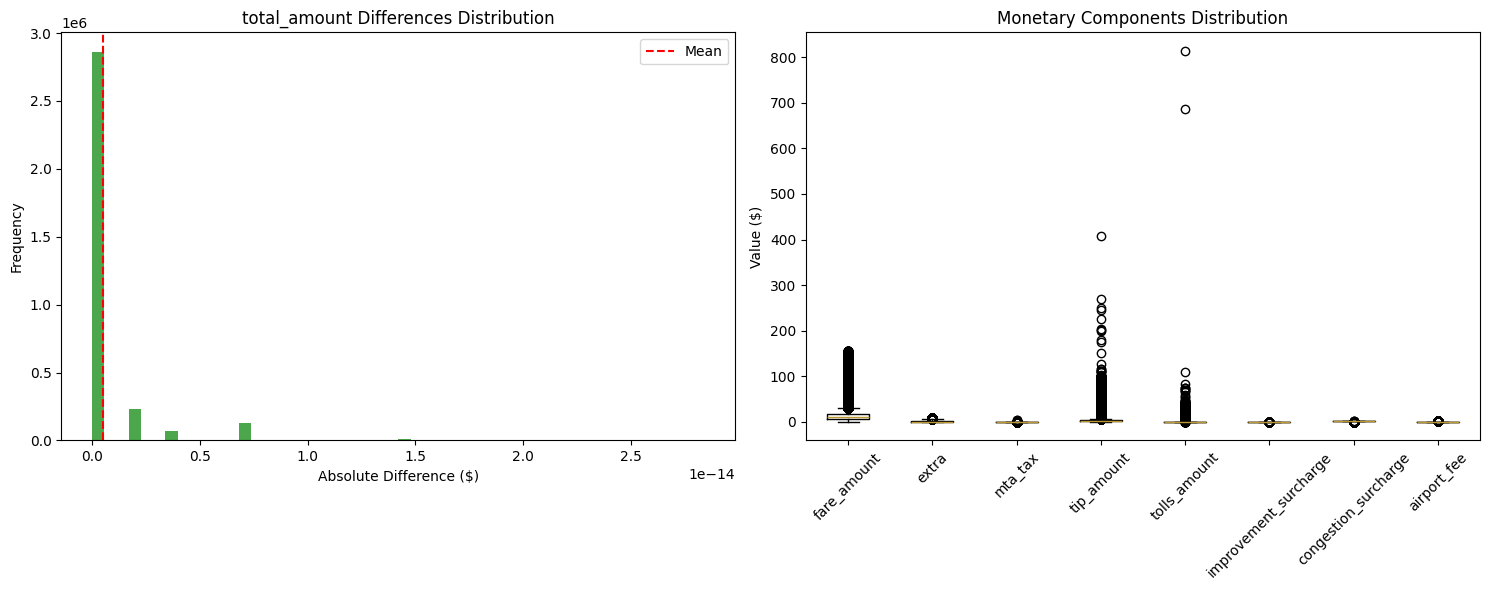

In [8]:
# Execute total_amount validation
print("🧠 total_amount VALIDATION")
print("="*50)

# Execute validation
validated_data = preprocessor.validate_total_amount()
total_validation_stats = preprocessor.preprocessing_stats['total_amount_validation']

print(f"\n🔍 total_amount VALIDATION RESULTS:")
print(f"   Discrepancies found: {total_validation_stats['discrepancies_found']:,}")
print(f"   Discrepancy percentage: {total_validation_stats['discrepancy_percentage']:.2f}%")

if total_validation_stats['discrepancies_found'] > 0:
    print(f"   Average difference: ${total_validation_stats['avg_difference']:.2f}")
    print(f"   Maximum difference: ${total_validation_stats['max_difference']:.2f}")
    print(f"   ✅ total_amount corrected based on component sum")
else:
    print(f"   ✅ No discrepancies found in total_amount")

# Verify consistency after correction
if len(preprocessor.df) > 0 and 'total_amount' in preprocessor.df.columns:
    print(f"\n🔍 POST-CORRECTION VERIFICATION:")
    
    # Recalculate components for verification
    base_fields = ['fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge']
    additional_fields = ['congestion_surcharge', 'airport_fee']
    
    calculated_total = pd.Series(0, index=preprocessor.df.index)
    
    for field in base_fields + additional_fields:
        if field in preprocessor.df.columns:
            calculated_total += preprocessor.df[field].fillna(0)
    
    # Verify remaining differences
    remaining_diff = abs(preprocessor.df['total_amount'] - calculated_total)
    significant_diff = (remaining_diff > 0.01).sum()
    
    print(f"   Records with differences > $0.01: {significant_diff:,}")
    print(f"   Maximum remaining difference: ${remaining_diff.max():.2f}")
    
    if significant_diff == 0:
        print(f"   ✅ total_amount is consistent with its components")
    
    # Visualization of differences distribution
    if len(remaining_diff) > 0:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Differences histogram
        ax1.hist(remaining_diff, bins=50, alpha=0.7, color='green')
        ax1.set_title('total_amount Differences Distribution')
        ax1.set_xlabel('Absolute Difference ($)')
        ax1.set_ylabel('Frequency')
        ax1.axvline(remaining_diff.mean(), color='red', linestyle='--', label='Mean')
        ax1.legend()
        
        # Monetary components boxplot
        monetary_components = [field for field in base_fields + additional_fields if field in preprocessor.df.columns]
        if monetary_components:
            component_data = [preprocessor.df[field].fillna(0) for field in monetary_components]
            ax2.boxplot(component_data, labels=monetary_components)
            ax2.set_title('Monetary Components Distribution')
            ax2.set_ylabel('Value ($)')
            ax2.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
else:
    print("⚠️ No data available to validate total_amount!")

## 9. Outlier Removal

2025-11-30 11:54:12,580 - INFO - === OUTLIER REMOVAL (IQR) ===


🎯 OUTLIER REMOVAL

📊 Records before outlier removal: 3,304,936


2025-11-30 11:54:12,780 - INFO - Outliers in trip_distance: 426,958 (12.92%)
2025-11-30 11:54:13,727 - INFO - Outliers in fare_amount: 74,343 (2.58%)
2025-11-30 11:54:13,727 - INFO - Outliers in fare_amount: 74,343 (2.58%)
2025-11-30 11:54:15,906 - INFO - Outliers in total_amount: 46,360 (1.65%)
2025-11-30 11:54:15,906 - INFO - Outliers in total_amount: 46,360 (1.65%)
2025-11-30 11:54:16,686 - INFO - Outliers in tip_amount: 15,877 (0.58%)
2025-11-30 11:54:16,686 - INFO - Outliers in tip_amount: 15,877 (0.58%)
2025-11-30 11:54:17,424 - INFO - Outliers in trip_duration_minutes: 37,227 (1.36%)
2025-11-30 11:54:17,424 - INFO - Outliers in trip_duration_minutes: 37,227 (1.36%)
2025-11-30 11:54:18,251 - INFO - Total outliers removed: 600,765
2025-11-30 11:54:18,252 - INFO - Remaining records: 2,704,171
2025-11-30 11:54:18,251 - INFO - Total outliers removed: 600,765
2025-11-30 11:54:18,252 - INFO - Remaining records: 2,704,171



🧹 OUTLIER REMOVAL RESULTS:
   Method used: IQR
   IQR factor: 1.5
   Records processed: 3,304,936
   Final records: 2,704,171
   Outliers removed: 600,765
   Percentage removed: 18.18%

🔍 STATISTICS POST-OUTLIER REMOVAL:

📊 Descriptive statistics after cleaning:


,trip_distance,fare_amount,total_amount,tip_amount,trip_duration_minutes
count,2704171.00,2704171.00,2704171.00,2704171.00,2704171.00
mean,1.95,9.88,16.09,1.95,11.77
std,1.24,4.11,4.97,1.40,6.10
min,0.01,0.01,1.30,0.00,1.00
25%,1.05,6.50,12.36,1.00,6.97
50%,1.63,9.00,15.36,2.00,10.78
75%,2.50,12.50,19.13,2.95,15.72
max,7.43,23.20,30.83,5.90,29.42


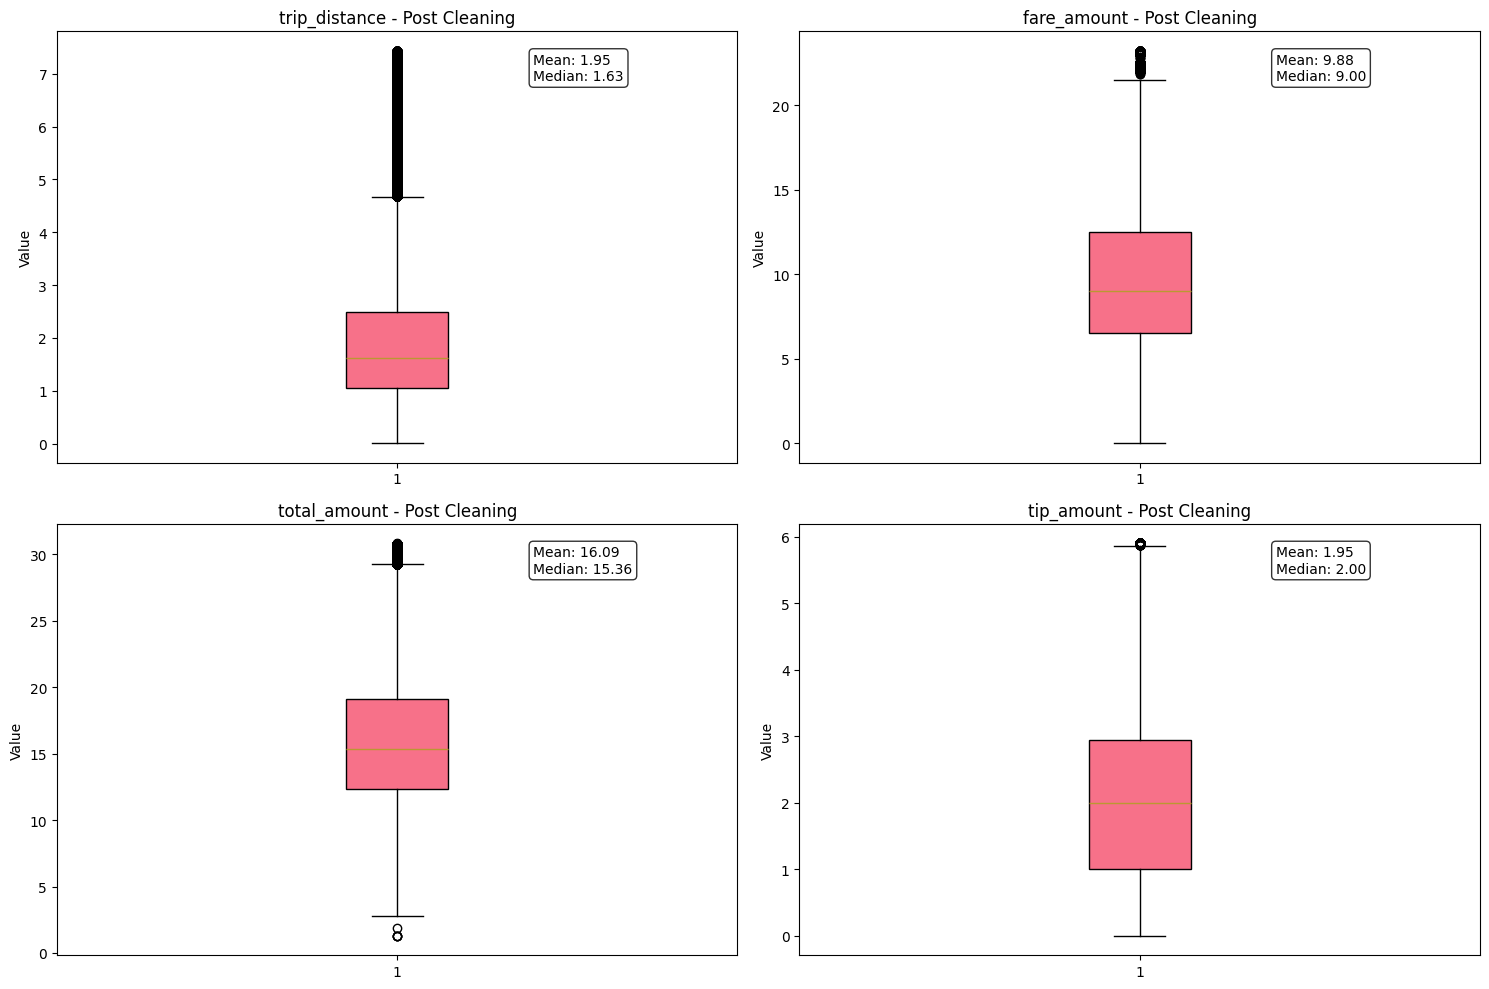


📏 FINAL DATA RANGES:
   trip_distance: Min=0.01, Q25=1.05, Q75=2.50, Max=7.43
   fare_amount: Min=0.01, Q25=6.50, Q75=12.50, Max=23.20
   total_amount: Min=1.30, Q25=12.36, Q75=19.13, Max=30.83
   fare_amount: Min=0.01, Q25=6.50, Q75=12.50, Max=23.20
   total_amount: Min=1.30, Q25=12.36, Q75=19.13, Max=30.83
   tip_amount: Min=0.00, Q25=1.00, Q75=2.95, Max=5.90
   trip_duration_minutes: Min=1.00, Q25=6.97, Q75=15.72, Max=29.42
   tip_amount: Min=0.00, Q25=1.00, Q75=2.95, Max=5.90
   trip_duration_minutes: Min=1.00, Q25=6.97, Q75=15.72, Max=29.42


In [9]:
# Execute outlier removal
print("🎯 OUTLIER REMOVAL")
print("="*50)

# Get statistics before removal
initial_count = len(preprocessor.df)
print(f"\n📊 Records before outlier removal: {initial_count:,}")

# Execute outlier removal
cleaned_outliers = preprocessor.remove_outliers(method='iqr', factor=1.5)
outlier_stats = preprocessor.preprocessing_stats['outlier_removal']

print(f"\n🧹 OUTLIER REMOVAL RESULTS:")
print(f"   Method used: {outlier_stats['method'].upper()}")
print(f"   IQR factor: {outlier_stats['factor']}")
print(f"   Records processed: {outlier_stats['initial_count']:,}")
print(f"   Final records: {outlier_stats['final_count']:,}")
print(f"   Outliers removed: {outlier_stats['outliers_removed']:,}")
print(f"   Percentage removed: {outlier_stats['removal_percentage']:.2f}%")

# Verify distribution after outlier removal
if len(preprocessor.df) > 0:
    print(f"\n🔍 STATISTICS POST-OUTLIER REMOVAL:")
    
    # Campos analizados para outliers
    outlier_fields = ['trip_distance', 'fare_amount', 'total_amount', 'tip_amount']
    if 'trip_duration_minutes' in preprocessor.df.columns:
        outlier_fields.append('trip_duration_minutes')
    
    existing_fields = [field for field in outlier_fields if field in preprocessor.df.columns]
    
    if existing_fields:
        # Show descriptive statistics
        print("\n📊 Descriptive statistics after cleaning:")
        stats_df = preprocessor.df[existing_fields].describe()
        display(stats_df.round(2))
        
        # Visualization before/after (simulation for demo)
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()
        
        for i, field in enumerate(existing_fields[:4]):
            if i < len(axes):
                # Boxplot to show the cleaned distribution
                axes[i].boxplot(preprocessor.df[field], patch_artist=True)
                axes[i].set_title(f'{field} - Post Cleaning')
                axes[i].set_ylabel('Value')
                
                # Add statistics on the plot
                mean_val = preprocessor.df[field].mean()
                median_val = preprocessor.df[field].median()
                axes[i].text(0.7, 0.95, f'Mean: {mean_val:.2f}\nMedian: {median_val:.2f}', 
                           transform=axes[i].transAxes, verticalalignment='top',
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Hide unused subplots
        for i in range(len(existing_fields), len(axes)):
            axes[i].set_visible(False)
        
        plt.tight_layout()
        plt.show()
        
        # Show final ranges
        print(f"\n📏 FINAL DATA RANGES:")
        for field in existing_fields:
            min_val = preprocessor.df[field].min()
            max_val = preprocessor.df[field].max()
            q25 = preprocessor.df[field].quantile(0.25)
            q75 = preprocessor.df[field].quantile(0.75)
            print(f"   {field}: Min={min_val:.2f}, Q25={q25:.2f}, Q75={q75:.2f}, Max={max_val:.2f}")
else:
    print("⚠️ No data remains after outlier removal!")

## 10. Final Preprocessing Summary

📋 COMPLETE PREPROCESSING SUMMARY

📊 GENERAL STATISTICS:
   Original records: 3,588,295
   Original columns: 19
   Final records: 2,704,171
   Final columns: 20
   Records removed: 884,124
   Retention percentage: 75.36%
   Removal percentage: 24.64%

🔄 STAGE-BY-STAGE DETAIL:

   🕒 Temporal Cleaning:
      Records removed: 54,154
      Percentage removed: 1.51%

   🏷️ Categorical Cleaning:
      Records removed: 198,181
      Percentage removed: 5.61%

   💰 Monetary Cleaning:
      Records removed: 31,024
      Percentage removed: 0.93%

   🧠 total_amount Validation:
      Discrepancies corrected: 927,828
      Discrepancy percentage: 28.07%

   🎯 Outlier Removal:
      Outliers removed: 600,765
      Percentage removed: 18.18%


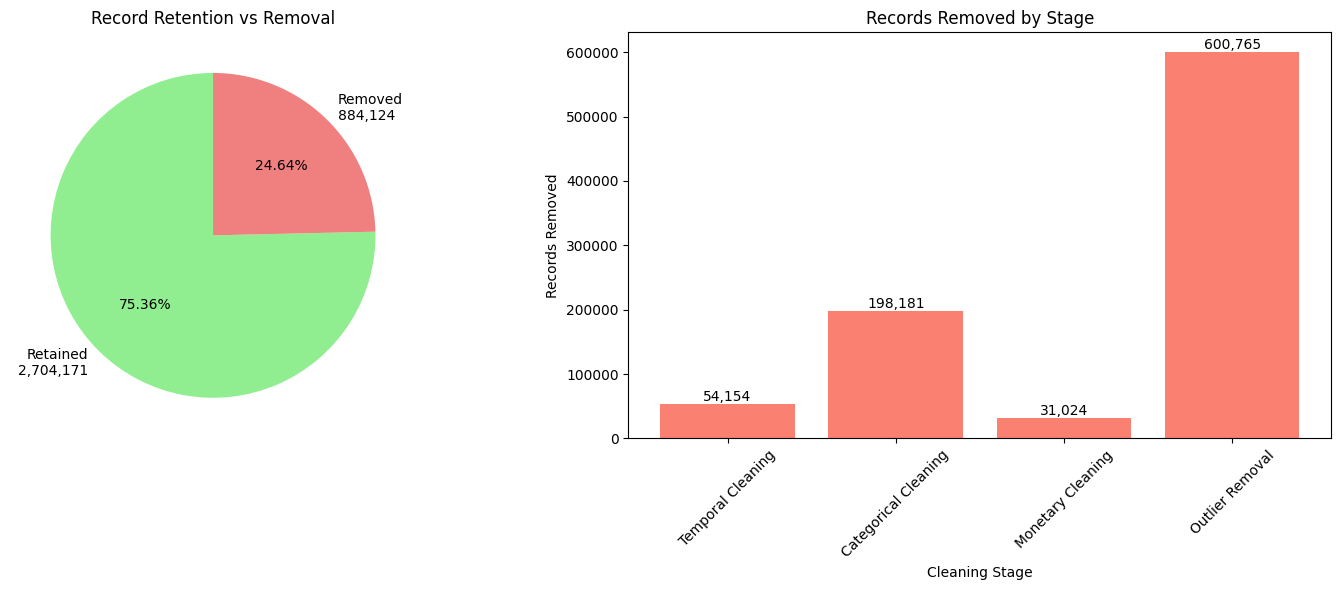


✅ PREPROCESSING COMPLETED

📁 NEXT STEPS:
   1. Save clean data to: d:\VSCode\nyc_taxi_project\data\processed\processed_data.parquet
   2. Proceed with feature engineering (features.py)
   3. Exploratory analysis of clean data
   4. Modeling and evaluation


In [10]:
# Get complete preprocessing summary
print("📋 COMPLETE PREPROCESSING SUMMARY")
print("="*60)

summary = preprocessor.get_preprocessing_summary()

if summary:
    print(f"\n📊 GENERAL STATISTICS:")
    print(f"   Original records: {summary['original_shape'][0]:,}")
    print(f"   Original columns: {summary['original_shape'][1]}")
    
    if summary['final_shape']:
        print(f"   Final records: {summary['final_shape'][0]:,}")
        print(f"   Final columns: {summary['final_shape'][1]}")
        print(f"   Records removed: {summary['total_removed']:,}")
        print(f"   Retention percentage: {100 - summary['removal_percentage']:.2f}%")
        print(f"   Removal percentage: {summary['removal_percentage']:.2f}%")
    
    print(f"\n🔄 STAGE-BY-STAGE DETAIL:")
    
    # Show statistics for each stage
    stages = [
        ('datetime_cleaning', '🕒 Temporal Cleaning'),
        ('categorical_cleaning', '🏷️ Categorical Cleaning'),
        ('monetary_cleaning', '💰 Monetary Cleaning'),
        ('total_amount_validation', '🧠 total_amount Validation'),
        ('outlier_removal', '🎯 Outlier Removal')
    ]
    
    for stage_key, stage_name in stages:
        if stage_key in summary['steps']:
            stage_data = summary['steps'][stage_key]
            print(f"\n   {stage_name}:")
            
            if stage_key == 'total_amount_validation':
                print(f"      Discrepancies corrected: {stage_data['discrepancies_found']:,}")
                print(f"      Discrepancy percentage: {stage_data['discrepancy_percentage']:.2f}%")
            else:
                if 'removed_records' in stage_data:
                    print(f"      Records removed: {stage_data['removed_records']:,}")
                    print(f"      Percentage removed: {stage_data['removal_percentage']:.2f}%")
                elif 'outliers_removed' in stage_data:
                    print(f"      Outliers removed: {stage_data['outliers_removed']:,}")
                    print(f"      Percentage removed: {stage_data['removal_percentage']:.2f}%")
    
    # Summary visualization
    if summary['final_shape']:
        # Bar chart showing retention vs removal
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Retention chart
        retained = summary['final_shape'][0]
        removed = summary['total_removed']
        
        ax1.pie([retained, removed], 
               labels=[f'Retained\n{retained:,}', f'Removed\n{removed:,}'],
               colors=['lightgreen', 'lightcoral'],
               autopct='%1.2f%%',
               startangle=90)
        ax1.set_title('Record Retention vs Removal')
        
        # Cleaning stages chart
        stage_removals = []
        stage_labels = []
        
        for stage_key, stage_name in stages:
            if stage_key in summary['steps']:
                stage_data = summary['steps'][stage_key]
                if 'removed_records' in stage_data:
                    stage_removals.append(stage_data['removed_records'])
                    stage_labels.append(stage_name.split(' ', 1)[1])  # Remove emoji
                elif 'outliers_removed' in stage_data:
                    stage_removals.append(stage_data['outliers_removed'])
                    stage_labels.append(stage_name.split(' ', 1)[1])  # Remove emoji
        
        if stage_removals:
            ax2.bar(stage_labels, stage_removals, color='salmon')
            ax2.set_title('Records Removed by Stage')
            ax2.set_xlabel('Cleaning Stage')
            ax2.set_ylabel('Records Removed')
            ax2.tick_params(axis='x', rotation=45)
            
            # Add values above bars
            for i, v in enumerate(stage_removals):
                ax2.text(i, v, f'{v:,}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()

print(f"\n✅ PREPROCESSING COMPLETED")
print(f"\n📁 NEXT STEPS:")
print(f"   1. Save clean data to: {PROCESSED_DATA}")
print(f"   2. Proceed with feature engineering (features.py)")
print(f"   3. Exploratory analysis of clean data")
print(f"   4. Modeling and evaluation")

## 11. Saving Clean Data

In [11]:
# Save processed data
print("💾 SAVING CLEAN DATA")
print("="*50)

try:
    output_path = preprocessor.save_processed_data()
    
    print(f"\n✅ DATA SAVED SUCCESSFULLY")
    print(f"   File: {output_path}")
    
    # Verify saved file
    if Path(output_path).exists():
        file_size = Path(output_path).stat().st_size / 1024**2
        print(f"   Size: {file_size:.2f} MB")
        
        # Verify loading of saved file
        test_load = pd.read_parquet(output_path)
        print(f"   Loading verification: ✅ {test_load.shape[0]:,} records loaded")
        
        print(f"\n📊 FINAL SUMMARY:")
        print(f"   Original dataset: {preprocessor.original_shape[0]:,} records")
        print(f"   Clean dataset: {len(preprocessor.df):,} records")
        print(f"   Data retention: {(len(preprocessor.df)/preprocessor.original_shape[0]*100):.2f}%")
        print(f"   Data quality: HIGH (outliers removed, values corrected)")
        
        del test_load  # Free memory
    
except Exception as e:
    print(f"❌ ERROR SAVING DATA: {e}")
    print(f"   Check write permissions and disk space")

print(f"\n🎯 CLEANING PIPELINE COMPLETED")
print(f"\n📋 DATA READY FOR:")
print(f"   ✅ Feature engineering (features.py)")
print(f"   ✅ Advanced exploratory analysis")
print(f"   ✅ Machine learning modeling")
print(f"   ✅ Temporal pattern analysis")
print(f"   ✅ Customer segmentation")

2025-11-30 11:54:43,373 - INFO - Saving processed data...


💾 SAVING CLEAN DATA


2025-11-30 11:55:25,990 - INFO - Processed data saved at: d:\VSCode\nyc_taxi_project\data\processed\processed_data.parquet
2025-11-30 11:55:25,992 - INFO - File size: 39.69 MB
2025-11-30 11:55:25,992 - INFO - File size: 39.69 MB



✅ DATA SAVED SUCCESSFULLY
   File: d:\VSCode\nyc_taxi_project\data\processed\processed_data.parquet
   Size: 39.69 MB
   Loading verification: ✅ 2,704,171 records loaded

📊 FINAL SUMMARY:
   Original dataset: 3,588,295 records
   Clean dataset: 2,704,171 records
   Data retention: 75.36%
   Data quality: HIGH (outliers removed, values corrected)

🎯 CLEANING PIPELINE COMPLETED

📋 DATA READY FOR:
   ✅ Feature engineering (features.py)
   ✅ Advanced exploratory analysis
   ✅ Machine learning modeling
   ✅ Temporal pattern analysis
   ✅ Customer segmentation
   Loading verification: ✅ 2,704,171 records loaded

📊 FINAL SUMMARY:
   Original dataset: 3,588,295 records
   Clean dataset: 2,704,171 records
   Data retention: 75.36%
   Data quality: HIGH (outliers removed, values corrected)

🎯 CLEANING PIPELINE COMPLETED

📋 DATA READY FOR:
   ✅ Feature engineering (features.py)
   ✅ Advanced exploratory analysis
   ✅ Machine learning modeling
   ✅ Temporal pattern analysis
   ✅ Customer segmenta